In [1]:
pip install pennylane numpy matplotlib scikit-learn scikit-image tensorflow opencv-python


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.0/930.0 kB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 46.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 51.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 55.4 MB/s eta 0:00:00


In [28]:
import pennylane as qml
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from skimage.transform import resize
import urllib.request
import os
import zipfile
import cv2

In [29]:
tf.config.run_functions_eagerly(True)

In [30]:
def download_pet_dataset():
    url = "https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz"
    filename = "images.tar.gz"

    if not os.path.exists("images"):
        urllib.request.urlretrieve(url, filename)
        os.system(f"tar -xzf {filename}")

    images_dir = "images"
    return images_dir

In [31]:
def load_pet_images(image_dir, img_size=(2, 2)):
    images = []
    labels = []

    for img_name in os.listdir(image_dir)[:1000]:  # Limit to 1000 images for speed
        img_path = os.path.join(image_dir, img_name)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
            img = resize(img, img_size, anti_aliasing=True)
            images.append(img.flatten())
            labels.append(1 if "cat" in img_name.lower() else 0)  # Cats -> 1, Dogs -> 0

    return np.array(images), np.array(labels)

In [32]:
image_dir = download_pet_dataset()
X, y = load_pet_images(image_dir)

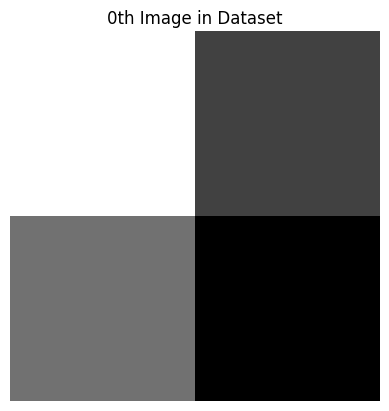

In [33]:
plt.imshow(X[0].reshape(2, 2), cmap='gray')
plt.title("0th Image in Dataset")
plt.axis("off")
plt.show()

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [35]:
def binary_encoding(X, threshold=0.5):
    return np.array([[1 if pixel > threshold else 0 for pixel in img] for img in X])

X_train = binary_encoding(X_train)
X_test = binary_encoding(X_test)

In [36]:
dev = qml.device("default.qubit", wires=4)

In [37]:
@qml.qnode(dev)
def quantum_circuit(data):
    for i in range(len(data)):
        if data[i] > 0:
            qml.X(wires=i)
    return qml.expval(qml.PauliZ(0))

In [38]:
class QuantumNeuralNetwork(tf.keras.Model):
    def __init__(self):
        super(QuantumNeuralNetwork, self).__init__()
        self.dense = layers.Dense(1, activation='sigmoid')

    def call(self, inputs):
        inputs = tf.reshape(inputs, (-1, 4))  # Flatten the inputs (batch_size, 4)
        quantum_results = np.array([quantum_circuit(img) for img in inputs.numpy()])
        quantum_results = quantum_results.reshape(-1, 1)
        return self.dense(quantum_results)

In [39]:
model = QuantumNeuralNetwork()
model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

In [40]:
history = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_split=0.15)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 0.4375 - loss: 0.9138 - val_accuracy: 0.4000 - val_loss: 0.9417
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.4169 - loss: 0.9182 - val_accuracy: 0.4000 - val_loss: 0.9223
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.4299 - loss: 0.8855 - val_accuracy: 0.4000 - val_loss: 0.9033
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 0.4054 - loss: 0.8929 - val_accuracy: 0.4000 - val_loss: 0.8843
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - accuracy: 0.4270 - loss: 0.8525 - val_accuracy: 0.4000 - val_loss: 0.8662
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - accuracy: 0.3799 - loss: 0.8813 - val_accuracy: 0.4000 - val_loss: 0.8479
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.3912 - loss: 0.8521 - val_accuracy: 0.4000 - val_loss: 0.8307
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - accuracy: 0.4060 - loss: 0.8210 - val_accuracy: 0.4000 - val_loss: 

In [41]:
eval_results = model.evaluate(X_test, y_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.4241 - loss: 0.7595


In [42]:
average_accuracy = np.mean(history.history['accuracy'])
print(f"Average Training Accuracy: {average_accuracy:.4f}")

Average Training Accuracy: 0.4083


In [43]:
def draw_circuit():
    qml.draw(quantum_circuit)(X_train[0])

draw_circuit()
plt.show()

In [44]:
plt.figure(figsize=(12, 6))

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

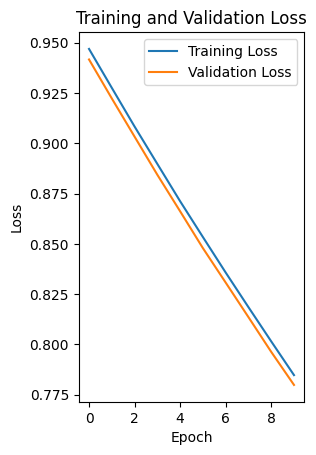

In [45]:
# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

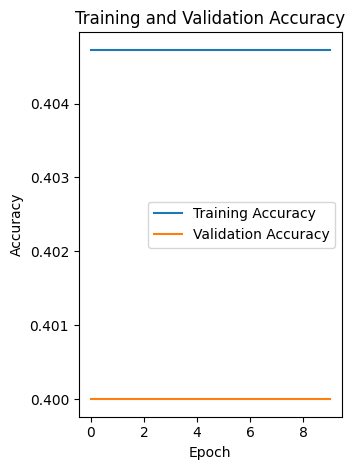

In [46]:
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()